In [110]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter,ImageOps
from keras.preprocessing import image
import random
import cv2
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, Reshape, LSTM, Bidirectional, TimeDistributed,BatchNormalization
import tensorflow as tf
import keras.backend as K
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn import preprocessing
import datetime
imageList = os.listdir('../dataset/LSTMData')


In [117]:
targetImageList = []
originalImageName = []
for img in imageList:
    try:
        name, extension = img.split('_')
        
        #create plain background for image
        image2 = image.load_img("../dataset/LSTMData/"+img, color_mode="grayscale")
        img = np.array(image2)
        (wt, ht) = (128, 32)
        (h, w) = img.shape
        fx = w / wt
        fy = h / ht
        f = max(fx, fy)
        newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
        img = cv2.resize(np.array(img), newSize)
        target = np.ones([ht, wt]) * 255
        target[0:newSize[1], 0:newSize[0]] = img
        
        #add image name
        originalImageName.append(name)
        
        #image transpose
        img = cv2.transpose(target)
        
        #normalize the image
        (m, s) = cv2.meanStdDev(img)
        m = m[0][0]
        s = s[0][0]
        img = img - m
        img = img / s if s>0 else img
        
        img = np.expand_dims(img, axis=2)
    
        targetImageList.append(img)
    except:
        print("error")
    

error


In [118]:
originalImageName[0]

'बनाइएको'

Label encoder

In [70]:
le = preprocessing.LabelEncoder()
imageName = le.fit_transform(originalImageName)
list(le.inverse_transform([691, 691]))

/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['कारोबारीको', 'कारोबारीको']

In [71]:
np.shape(targetImageList)

(10998, 128, 32, 1)

Splitting training data into train and test

In [10]:
xTrain, xTest, yTrain, yTest = train_test_split(targetImageList, imageName, test_size = 0.2, random_state = 0)

In [11]:
kernelVals = [5, 5, 3, 3, 3]
featureVals = [1, 32, 64, 128, 256]
strideVals = poolVals = [(2,2), (2,2), (1,2), (1,2), (1,2)]
numLayers = len(strideVals)
inShp=(128,32,1)

model = Sequential()
model.add(Conv2D(1, (1,1), padding="same",input_shape=inShp, activation='relu'))

for i in range(numLayers):
    model.add(Conv2D(featureVals[i], (poolVals[i][0], poolVals[i][1]), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(poolVals[i][0], poolVals[i][1]), strides=(poolVals[i][0], poolVals[i][1])))
           
numHidden = 256
inputSize = (None,4,1,128)
model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(LSTM((numHidden), batch_input_shape=(None,32,1,256), return_sequences=True)))
model.add(Bidirectional(LSTM((numHidden), return_sequences=True)))
model.add(Flatten())
model.add(Dense(10000, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])


In [12]:
try:
    input_shape =(None,128,32,1)
    model.build(input_shape)
    print(model.summary())
except AssertionError as assErr:
    print(assErr)
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 32, 1)        2         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 32, 1)        5         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 1)        4         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 16, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 16, 32)        160       
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 16, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 8, 32)         0         
__________

In [13]:
x_test = np.array(xTest)
y_test = np.array(yTest)
y_train = np.array(yTrain)
x_train = np.array(xTrain)
a = datetime.datetime.now()
history = model.fit(x_train,y_train,epochs=10,validation_data=(x_test, y_test))
b = datetime.datetime.now()
print(b-a)

Train on 8798 samples, validate on 2200 samples
Epoch 1/10
8798/8798 [==============================] - 1960s 223ms/step - loss: 7.3006 - acc: 0.1436 - val_loss: 6.6527 - val_acc: 0.1845
Epoch 2/10
8798/8798 [==============================] - 1922s 218ms/step - loss: 3.9117 - acc: 0.4509 - val_loss: 4.6069 - val_acc: 0.4527
Epoch 3/10
8798/8798 [==============================] - 3675s 418ms/step - loss: 2.0307 - acc: 0.6324 - val_loss: 4.0115 - val_acc: 0.5500
Epoch 4/10
8798/8798 [==============================] - 1702s 193ms/step - loss: 0.9241 - acc: 0.8218 - val_loss: 3.8775 - val_acc: 0.5936
Epoch 5/10
8798/8798 [==============================] - 1291s 147ms/step - loss: 0.3309 - acc: 0.9412 - val_loss: 3.7416 - val_acc: 0.6368
Epoch 6/10
8798/8798 [==============================] - 1628s 185ms/step - loss: 0.1246 - acc: 0.9794 - val_loss: 3.6099 - val_acc: 0.6614
Epoch 7/10
8798/8798 [==============================] - 3799s 432ms/step - loss: 0.0544 - acc: 0.9910 - val_loss: 3.50

In [14]:
score = model.evaluate(x_test,y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2200/2200 [==============================] - 31s 14ms/step
Test loss: 3.499572236321189
Test accuracy: 0.6836363638531078


In [27]:
model.save('saved_model/bilstm.h5')

In [16]:
model2 = keras.models.load_model('saved_model/bilstm.h5', compile=False)

In [17]:
result = model2.predict(x_test)

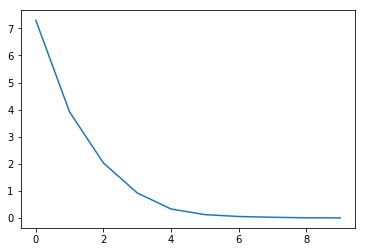

In [18]:
plt.plot(history.history['loss'])
plt.show()

In [37]:
result.size

200000

In [53]:
test_image = np.expand_dims(xTest[100], axis = 0)
prediction = model2.predict(test_image)
test_image.shape

(1, 128, 32, 1)

In [54]:
predicted_class = np.argmax(prediction[0])
print(predicted_class)
print(le.inverse_transform(predicted_class))

2123
निर्माण


/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


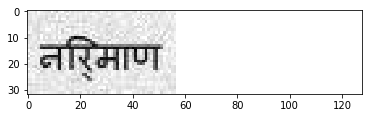

In [45]:
targetImg = np.reshape(xTest[100],(128,32))
transposedImage = cv2.transpose(targetImg)
plt.imshow(transposedImage,cmap='gray')

# Save Token

In [36]:
with open("token.txt", "w") as txt_file:
    for line in le.classes_:
        txt_file.write("".join(line) + "\n")